<a href="https://colab.research.google.com/github/OlyKoek/Udemy-AIperfectMaster-colabo/blob/main/Section13/make_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# モデルの訓練と保存
Google Colaboratoryで画像識別用のモデルを構築し、訓練します。  
今回は、cifar-10を訓練データに使います。  
訓練済みのモデルは保存し、ダウンロードします。

## バージョンの確認
念のために、以下のコードによりtensorflowとKerasのバージョンを確認しておきましょう。

In [2]:
import tensorflow as tf
import keras
print(tf.__version__)
print(keras.__version__)

2.19.0
3.10.0


## 使用ライブラリ

In [3]:
# 必要ライブラリ
import numpy as np
import matplotlib.pyplot as plt

from keras.datasets import cifar10 # 10 category dataset
from keras.models import Sequential
from keras import Input
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from keras.optimizers import Adam

from keras.models import Model
from keras.callbacks import LambdaCallback

## 訓練データの読み込み
前のImageDataGeneratorが廃止になっていたので、tensorflow.keras.preprocessing.image import ImageDataGeneratorに変更。


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
x_train.shape: (50000, 32, 32, 3)
x_train.dtype: uint8
x_train range 0.0 -> 255.0
dtype: uint8


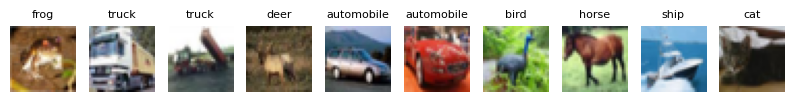

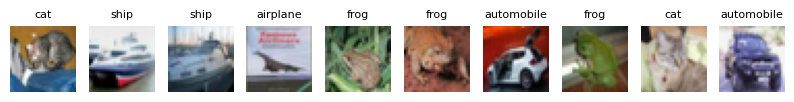

In [4]:
# データ読み込み
(x_train, t_train), (x_test, t_test) = cifar10.load_data()

# データの可視化 cifar10
classes = ['airplane','automobile','bird','cat','deer',
           'dog','frog','horse','ship','truck']

# データの確認
print("x_train.shape:", x_train.shape)
print("x_train.dtype:", x_train.dtype)
print("x_train range", float(x_train.min()), "->", float(x_train.max()))
print("dtype:", x_train.dtype)

plt.figure(figsize=(10,2))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(x_train[i])
    plt.axis("off")
    plt.title(classes[t_train[i,0]], fontsize=8)
plt.show()

plt.figure(figsize=(10,2))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(x_test[i])
    plt.axis("off")
    plt.title(classes[t_test[i,0]], fontsize=8)
plt.show()

In [5]:
# 前処理（float32にキャストして正規化して学習の安定化を図る）
x_train_norm = x_train.astype("float32") / 255.0
x_test_norm  = x_test.astype("float32") / 255.0

# データの確認
print("x_train.shape:", x_train_norm.shape)
print("x_train.dtype:", x_train_norm.dtype)
print("x_train range", float(x_train_norm.min()), "->", float(x_train_norm.max()))
print("dtype:", x_train_norm.dtype)

x_train.shape: (50000, 32, 32, 3)
x_train.dtype: float32
x_train range 0.0 -> 1.0
dtype: float32


t_train to onehot shape: (50000, 1) -> (50000, 10)
t_train to onehot dtype: uint8 -> float64
t_train onehot range 0.0 -> 1.0


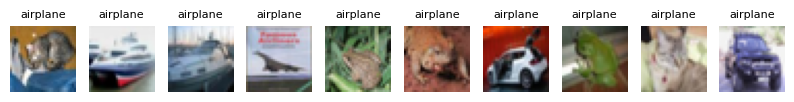

In [6]:
# one-hot convert
n_class = 10
t_train_onehot = keras.utils.to_categorical(t_train, n_class)
t_test_onehot  = keras.utils.to_categorical(t_test, n_class)

# one-hot後のデータの確認
print("t_train to onehot shape:", t_train.shape, "->", t_train_onehot.shape)
print("t_train to onehot dtype:", t_train.dtype, "->", t_train_onehot.dtype)
print("t_train onehot range", float(t_train_onehot.min()), "->", float(t_train_onehot.max()))

plt.figure(figsize=(10,2))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(x_test[i])
    plt.axis("off")
    cls_id = int(t_test[i].argmax())
    plt.title(classes[cls_id], fontsize=8)
plt.show()

## モデルの構築
CNNのモデルを構築します。

In [7]:
model = Sequential([
    # TensroFlowの入力引数に画像情報を設定(heig:32,width:32,channel:3)
    # batchサイズは自動とのこと。
    Input(shape=x_train_norm.shape[1:]),

    # 畳込層の設定。
    # (3,3)ピクセル単位で周辺情報を抽出
    # same:出力のサイズを入力と同じに保つ
    Conv2D(32, (3, 3), padding="same"), Activation("relu"),
    Conv2D(32, (3, 3)), Activation("relu"),

    # Poolic層
    # 特徴を圧縮して、重要情報だけを抽出する
    # 2*2の範囲で最大値を取る＝画像サイズが30->15のように圧縮される。
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), padding="same"), Activation("relu"),
    Conv2D(64, (3, 3)), Activation("relu"),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(256), Activation("relu"),
    Dropout(0.5),
    Dense(n_class), Activation("softmax"),
])

model.compile(optimizer=Adam(), loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 30, 30, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 15, 15, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 15, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 13, 13, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 10)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 658,218 (2.51 MB)

 Trainable params: 658,218 (2.51 MB)

 Non-trainable params: 0 (0.00 B)

### (次の学習で可視化に使用する作業用の関数)

In [8]:
def show_feature_maps(epoch, logs):
    if epoch % 5 == 0 or epoch == 0:  # 5エポックごとに表示
        test_img = x_test_norm[:1]                         # idx=0 固定
        activations = activation_model.predict(test_img, verbose=0)
        first_layer_act = activations[0][0]                # Conv1 の特徴マップ (H, W, C)

        label_id = int(t_test_onehot[0].argmax())          # idx=0 の正解ラベル

        n_show = 4 # 確認用に表示する特徴フィルタの数
        fig, axes = plt.subplots(1, n_show+1, figsize=(8, 2), constrained_layout=True)

        # 比較用に元画像を一番左に追加
        axes[0].imshow(x_test_norm[0])
        axes[0].axis('off')
        axes[0].set_title(f"{classes[label_id]}", fontsize=8)

        for i in range(n_show):
            axes[i+1].imshow(first_layer_act[:, :, i], cmap='viridis') # 0-i番目までのフィルタ特徴画像の出力
            axes[i+1].axis('off')
            axes[i+1].set_title(f"ch {i}", fontsize=8)

        fig.suptitle(f"Epoch {epoch} | idx=0 | label={classes[label_id]}")
        plt.show()

## 学習
モデルを訓練します。  
ImageDataGeneratorを使用する際は、学習にfit_generatorメソッドを使います。  
学習には時間がかかりますので、編集→ノートブックの設定のハードウェアアクセラレーターでGPUを選択しましょう。

Epoch 1/15
1560/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8550 - loss: 0.4005

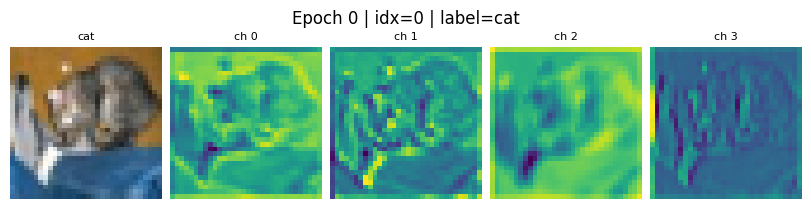

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.8550 - loss: 0.4005 - val_accuracy: 0.7628 - val_loss: 0.8244
Epoch 2/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8643 - loss: 0.3764 - val_accuracy: 0.7597 - val_loss: 0.8643
Epoch 3/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8678 - loss: 0.3613 - val_accuracy: 0.7620 - val_loss: 0.8332
Epoch 4/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8822 - loss: 0.3317 - val_accuracy: 0.7627 - val_loss: 0.8908
Epoch 5/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8872 - loss: 0.3179 - val_accuracy: 0.7686 - val_loss: 0.8904
Epoch 6/15
1550/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8862 - loss: 0.3149

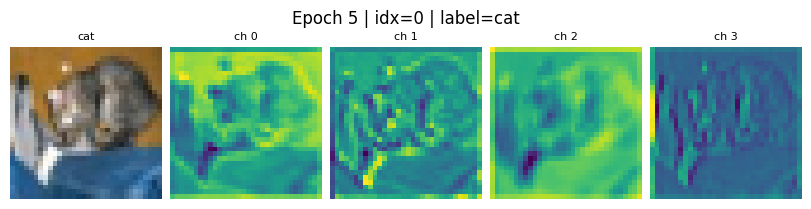

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8862 - loss: 0.3150 - val_accuracy: 0.7608 - val_loss: 0.9063
Epoch 7/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.8927 - loss: 0.2910 - val_accuracy: 0.7645 - val_loss: 0.9225
Epoch 8/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8936 - loss: 0.2952 - val_accuracy: 0.7559 - val_loss: 0.9752
Epoch 9/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8954 - loss: 0.2885 - val_accuracy: 0.7566 - val_loss: 0.9687
Epoch 10/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8996 - loss: 0.2835 - val_accuracy: 0.7687 - val_loss: 0.9639
Epoch 11/15
1554/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9039 - loss: 0.2712

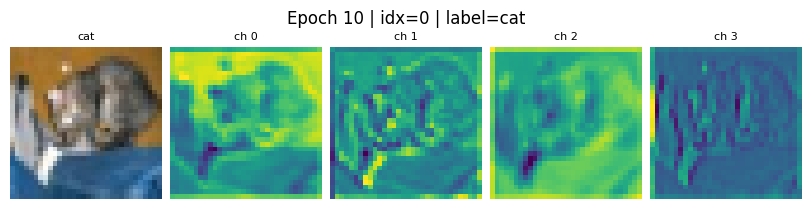

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9038 - loss: 0.2713 - val_accuracy: 0.7720 - val_loss: 1.0649
Epoch 12/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9033 - loss: 0.2747 - val_accuracy: 0.7618 - val_loss: 1.0177
Epoch 13/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9089 - loss: 0.2548 - val_accuracy: 0.7571 - val_loss: 0.9984
Epoch 14/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9074 - loss: 0.2584 - val_accuracy: 0.7553 - val_loss: 1.1989
Epoch 15/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9119 - loss: 0.2515 - val_accuracy: 0.7671 - val_loss: 1.0959


In [13]:
# HP
batch_size = 32
epochs = 15

# === 学習の可視化設定 ===
# convの層の出力を取得
conv_layers = [l for l in model.layers if isinstance(l, Conv2D)]
conv_outputs = [l.output for l in conv_layers]
activation_model = Model(inputs=model.inputs, outputs=conv_outputs)

# Callbackを登録＆Fit関数に渡す
cb_feat = LambdaCallback(on_epoch_end=show_feature_maps)
# ====================

# === 学習 ===
history = model.fit(
    x_train_norm, t_train_onehot,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_test_norm, t_test_onehot),
    shuffle=True,
    callbacks=[cb_feat]
)

## 学習の推移
学習の推移を表示します。  

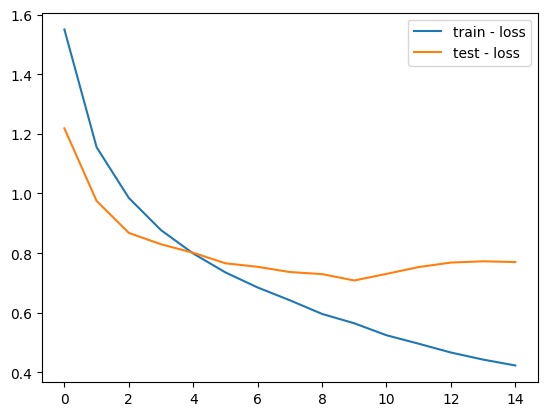

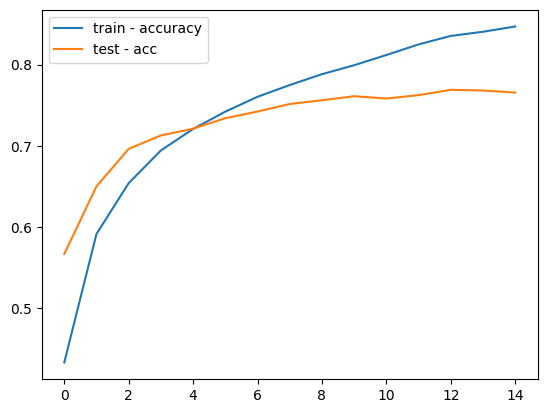

In [10]:
# 学習曲線
train_loss = history.history["loss"]
val_loss = history.history["val_loss"]
train_acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

plt.plot(np.arange(len(train_loss)), train_loss, label="train - loss")
plt.plot(np.arange(len(val_loss)), val_loss, label="test - loss")
plt.legend(); plt.show()

plt.plot(np.arange(len(train_acc)), train_acc, label="train - accuracy")
plt.plot(np.arange(len(val_acc)), val_acc, label="test - acc")
plt.legend(); plt.show()

## 評価
モデルの評価を行います。  

In [11]:
# 評価
loss, accuracy = model.evaluate(x_test_norm, t_test_onehot)
print("loss:", loss, "accuracy:", accuracy)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7684 - loss: 0.7518
loss: 0.7699005007743835 accuracy: 0.7656000256538391


## モデルの保存とダウンロード
他の環境でも使えるように、モデルを保存しダウンロードします。

In [12]:
from google.colab import files

# 保存とダウンロード（.h5 で保存したい場合は h5py が必要）
from google.colab import files
model.save("image_classifier.keras", include_optimizer=False)
files.download("image_classifier.keras")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>